In [57]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import joblib
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


In [58]:
df=pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [59]:
df.drop(['CustomerID'], axis=1, inplace=True)

In [60]:
df.isna().sum()

Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [61]:
df.duplicated().sum()

np.int64(0)

In [62]:
encoder=LabelEncoder()
df['Genre'] = encoder.fit_transform(df['Genre'])

In [63]:
scaler=StandardScaler()
df_scaled = scaler.fit_transform(df.select_dtypes(include=['float64', 'int64']))           
df_scaled = pd.DataFrame(df, columns=df.select_dtypes(include=['float64', 'int64']).columns)

In [64]:
df.describe()

,Genre,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,0.440000,38.850000,60.560000,50.200000
std,0.497633,13.969007,26.264721,25.823522
min,0.000000,18.000000,15.000000,1.000000
25%,0.000000,28.750000,41.500000,34.750000
50%,0.000000,36.000000,61.500000,50.000000
75%,1.000000,49.000000,78.000000,73.000000
max,1.000000,70.000000,137.000000,99.000000


In [65]:
upper_bound = {}
lower_bound = {}

for col in df.columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    upper_bound[col] = q3 + 1.5 * iqr
    lower_bound[col] = q1 - 1.5 * iqr

for col in df.columns:
    df = df[(df[col] >= lower_bound[col]) & (df[col] <= upper_bound[col])]

In [66]:
model = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(df)


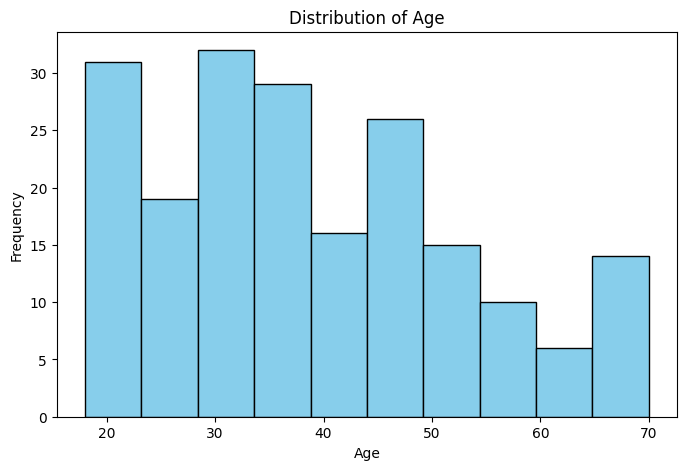

In [67]:
plt.figure(figsize=(8, 5))
plt.hist(df['Age'], bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


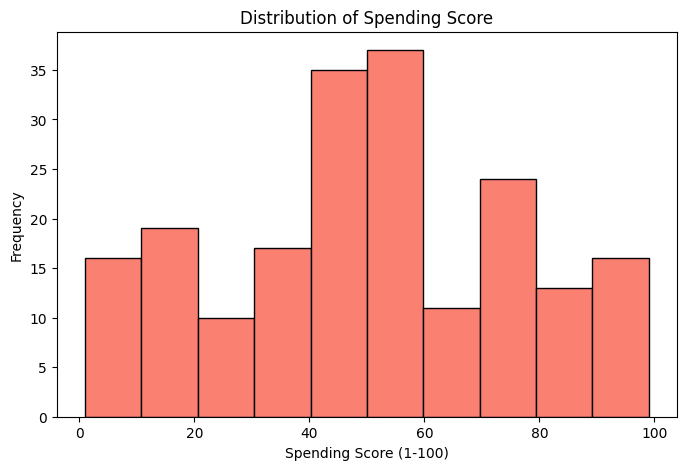

In [68]:
plt.figure(figsize=(8, 5))
plt.hist(df['Spending Score (1-100)'], bins=10, color='salmon', edgecolor='black')
plt.title('Distribution of Spending Score')
plt.xlabel('Spending Score (1-100)')
plt.ylabel('Frequency')
plt.show()


In [69]:
df_scaled.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40


In [70]:
pca = PCA(n_components=2, random_state=42)
x = pca.fit_transform(df_scaled)

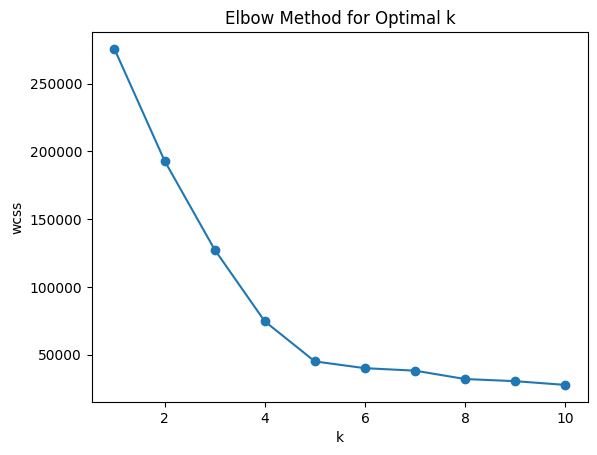

In [71]:
WCSS = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x)
    WCSS.append(kmeans.inertia_)

plt.plot(range(1,11), WCSS, marker='o')
plt.xlabel('k')
plt.ylabel('wcss')
plt.title('Elbow Method for Optimal k')
plt.show()

In [72]:
model = KMeans(n_clusters=5, random_state=42)
labels = model.fit_predict(x)


In [73]:
df_scaled['Cluster'] = labels


In [74]:
df_scaled

,Genre,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1,19,15,39,4
1,1,21,15,81,2
2,0,20,16,6,4
3,0,23,16,77,2
4,0,31,17,40,4
...,...,...,...,...,...
195,0,35,120,79,1
196,0,45,126,28,3
197,1,32,126,74,1
198,1,32,137,18,3


In [75]:
df_scaled.describe()

,Genre,Age,Annual Income (k$),Spending Score (1-100),Cluster
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.440000,38.850000,60.560000,50.200000,1.385000
std,0.497633,13.969007,26.264721,25.823522,1.448192
min,0.000000,18.000000,15.000000,1.000000,0.000000
25%,0.000000,28.750000,41.500000,34.750000,0.000000
50%,0.000000,36.000000,61.500000,50.000000,1.000000
75%,1.000000,49.000000,78.000000,73.000000,3.000000
max,1.000000,70.000000,137.000000,99.000000,4.000000


<Axes: xlabel='Annual Income (k$)', ylabel='Spending Score (1-100)'>

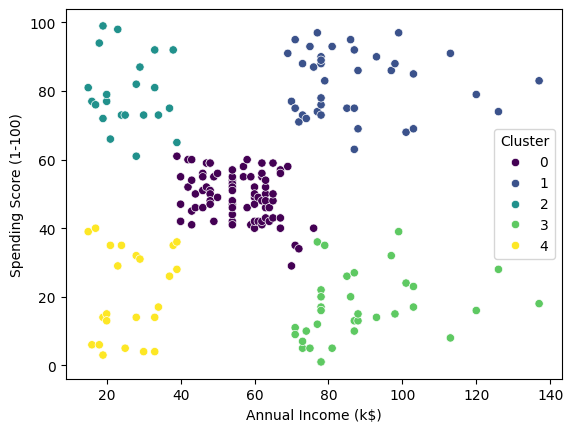

In [76]:
sns.scatterplot(data=df_scaled, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster', palette='viridis')

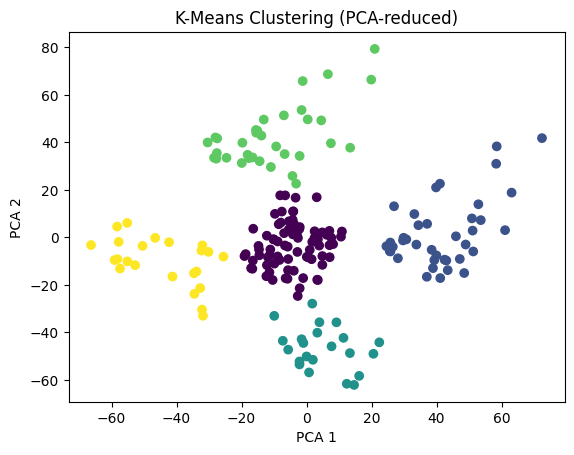

In [77]:
plt.scatter(x[:, 0], x[:, 1], c=labels, cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('K-Means Clustering (PCA-reduced)')
plt.show()

In [78]:
features = df_scaled.drop('Spending Score (1-100)', axis=1)
target = df_scaled['Spending Score (1-100)']

In [79]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [82]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from xgboost import XGBRegressor

params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0, 0.01, 0.1, 1]
}

random_search = RandomizedSearchCV(
    XGBRegressor(),
    param_distributions=params,
    n_iter=60,           # Try 50 random combinations
    scoring='r2',
    cv=5,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

random_search.fit(x_train, y_train)

from sklearn.metrics import mean_squared_error

print("Best Parameters:", random_search.best_params_)
print("Best R² Score:", random_search.best_score_)
print("MSE Score:", mean_squared_error(y_test, random_search.predict(x_test)))


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Parameters: {'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.4, 'colsample_bytree': 0.6}
Best R² Score: 0.8342904686927796
MSE Score: 88.96778869628906


In [84]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = random_search.predict(x_test)
print("Test R² Score:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred))


Test R² Score: 0.819625735282898
RMSE: 88.96778869628906


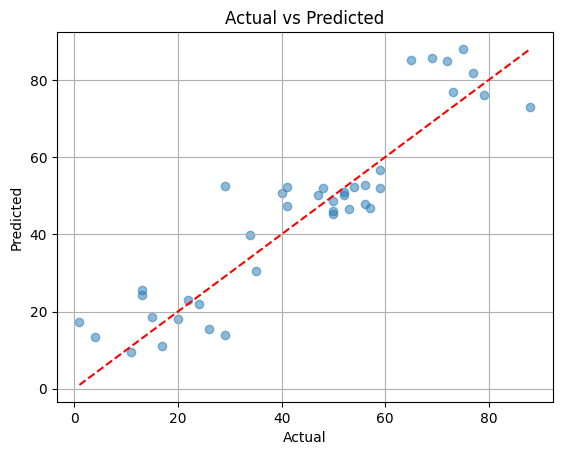

In [85]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.grid(True)
plt.show()


In [ ]:
fbf